# $F\rightarrow F'$ 1D molasses

This example covers calculating the forces in a one-dimensional optical molasses
using the optical bloch equations.  It reproduces Fig. 1 of Devlin, J. A. and
Tarbutt, M. R.  ‘Three-dimensional Doppler, polarization-gradient, and
magneto-optical forces for atoms and molecules with dark states’, *New Journal of
Physics*, **18** 123017 (2016). http://dx.doi.org/10.1088/1367-2630/18/12/123017.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp

### Define the problem

For this particular example, we want to run multiple polarizations and multiple Hamiltonians, but all with the same detuning and intensity.  So we'll make a dictionary of `laserBeams` objects corresponding to different polarizations and a dictionary of `hamiltonian` objects, keyed by the relevant ground and excited states.

In [2]:
det = -2.5
s = 1.0

laserBeams = {}
laserBeams['$\\sigma^+\\sigma^-$'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]),
     'pol_coord':'spherical', 'delta':0, 's':s},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'spherical', 'delta':0, 's':s},
    ], beam_type=pylcp.infinitePlaneWaveBeam)

phi = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
phi_keys = ['$\phi=0$', '$\phi=\pi/8$', '$\phi=\pi/4$', '$\phi=3\pi/8$', '$\phi=\pi/2$']
for phi_i, key_beam in zip(phi, phi_keys):
    laserBeams[key_beam] = pylcp.laserBeams([
        {'kvec':np.array([0., 0., 1.]), 'pol':np.array([1., 0., 0.]),
         'pol_coord':'cartesian', 'delta':0, 's':s},
        {'kvec':np.array([0., 0., -1.]),
         'pol':np.array([np.cos(phi_i), np.sin(phi_i), 0.]),
         'pol_coord':'cartesian', 'delta':0, 's':s}
        ], beam_type=pylcp.infinitePlaneWaveBeam)

hamiltonian = {}
for Fg, Fe in zip([1, 1, 2], [2, 1, 1]):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fg, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fe, gF=1/Fe, muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fg, Fe)
    hamiltonian['Fg%d;Fe%d'%(Fg,Fe)] = pylcp.hamiltonian(
        Hg, He - det*np.eye(2*Fe+1), Bgq, Beq, dijq
        )

magField = pylcp.constantMagneticField(np.zeros((3,)))

### Calculate equilibrium forces

Next, we calculate the equilibrium forces, making a compound dictionary of `obe` objects that is keyed by both the relevant ground and excited states _and_ polarizations

In [3]:
obe = {}
v = np.concatenate((np.arange(0.0, 0.1, 0.001),
                    np.arange(0.1, 5.1, 0.1)))
#v = np.arange(-0.1, 0.1, 0.01)

for key_ham in hamiltonian.keys():
    if key_ham not in obe.keys():
        obe[key_ham] = {}

    for key_beam in laserBeams.keys():
        print('Running %s w/ %s' % (key_ham, key_beam) + '...')
        obe[key_ham][key_beam] = pylcp.obe(laserBeams[key_beam],
                                           magField, hamiltonian[key_ham],
                                           transform_into_re_im=True,
                                           use_sparse_matrices=False)

        obe[key_ham][key_beam].generate_force_profile(
            [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
            [np.zeros(v.shape), np.zeros(v.shape), v],
            name='molasses', deltat_v=4, deltat_tmax=2*np.pi*5000, itermax=1000,
            rel=1e-8, abs=1e-10, progress_bar=True
        )

Running Fg1;Fe2 w/ $\sigma^+\sigma^-$...
Completed in 8:27.                                                  
Running Fg1;Fe2 w/ $\phi=0$...
Completed in 6:34.                                                  
Running Fg1;Fe2 w/ $\phi=\pi/8$...
Completed in 7:08.                                                  
Running Fg1;Fe2 w/ $\phi=\pi/4$...
Completed in 6:54.                                                  
Running Fg1;Fe2 w/ $\phi=3\pi/8$...
Completed in 7:09.                                                  
Running Fg1;Fe2 w/ $\phi=\pi/2$...
Completed in 7:42.                                                  
Running Fg1;Fe1 w/ $\sigma^+\sigma^-$...
Completed in 4:07.                                                  
Running Fg1;Fe1 w/ $\phi=0$...
Completed in 5:23.                                                  
Running Fg1;Fe1 w/ $\phi=\pi/8$...
Completed in 7:28.                                                  
Running Fg1;Fe1 w/ $\phi=\pi/4$...
Completed in 7:18.      

Plot up the results:

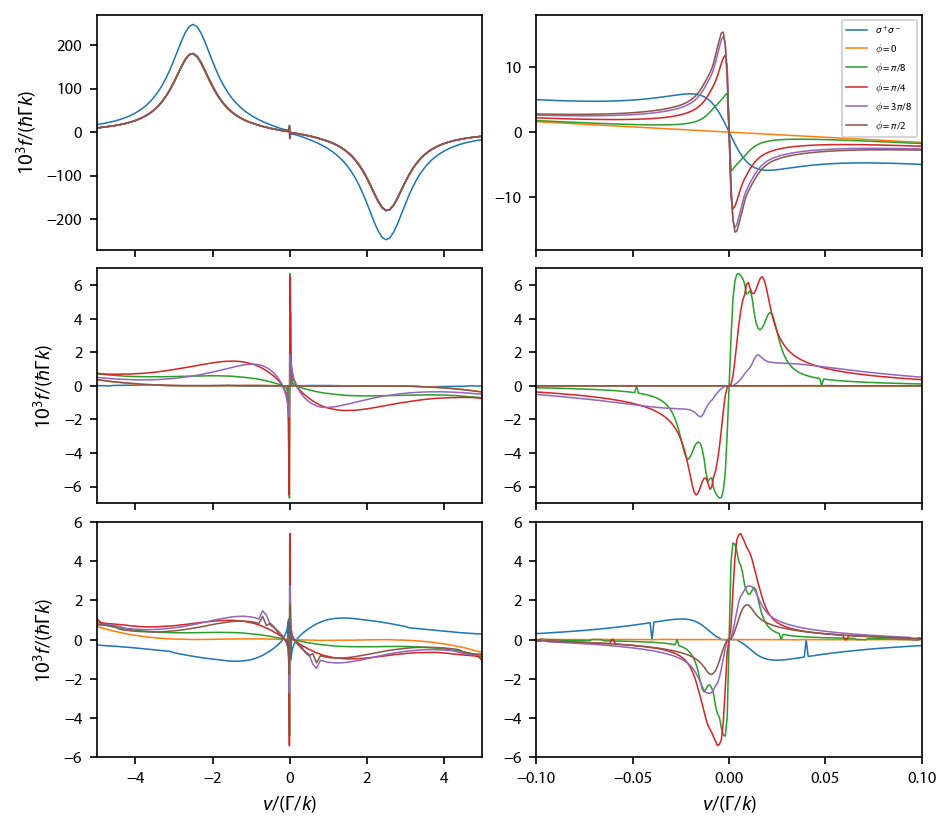

In [4]:
fig, ax = plt.subplots(3, 2, num='F=1->F=2', figsize=(6.25, 2*2.75))

ylims = [[270, 7, 6], [18, 7, 6]]
for ii, key_ham in enumerate(hamiltonian.keys()):
    for key_beam in laserBeams.keys():
        ax[ii, 0].plot(np.concatenate((-v[::-1], v)),
                        1e3*np.concatenate(
                            (-obe[key_ham][key_beam].profile['molasses'].F[2][::-1],
                             obe[key_ham][key_beam].profile['molasses'].F[2])
                            ),
                       label=key_beam, linewidth=0.75)
        ax[ii, 1].plot(np.concatenate((-v[::-1], v)),
                        1e3*np.concatenate(
                            (-obe[key_ham][key_beam].profile['molasses'].F[2][::-1],
                             obe[key_ham][key_beam].profile['molasses'].F[2])
                            ),
                       label=key_beam, linewidth=0.75)

    ax[ii, 0].set_xlim((-5, 5))
    ax[ii, 1].set_xlim((-0.1, 0.1))
    ax[ii, 0].set_ylim((-ylims[0][ii], ylims[0][ii]))
    ax[ii, 1].set_ylim((-ylims[1][ii], ylims[1][ii]))

ax[-1, 0].set_xlabel('$v/(\Gamma/k)$')
ax[-1, 1].set_xlabel('$v/(\Gamma/k)$')
for ii in range(len(hamiltonian)):
    ax[ii, 0].set_ylabel('$10^3 f/(\hbar\Gamma k)$')

for ii in range(len(hamiltonian)-1):
    for jj in range(2):
        ax[ii, jj].set_xticklabels([])

ax[0, 1].legend(fontsize=5)
fig.subplots_adjust(wspace=0.14, hspace=0.08, left=0.1, bottom=0.08)

The results agree very well with Devlin, *et. al.*, with the exception of a few glitches in the type-II molasses where the convergence criterion for the equilibrium force clearly failed.